In [232]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

2.3.0


In [2]:
# from constants import *;
# from NN_predict_v1 import *;

In [233]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

In [262]:
MONTHS = 72;
SPLIT = 60; # 2014-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 30;
WINDOW_SIZE = 1;

TEST_LENGTH = MONTHS - SPLIT;

### Preparing data

Yeah, this one should be the same thing as what we have done for a while...

In [263]:
multi_data = pd.read_csv('../data/zri_acs_bikeshare_merged.csv', index_col = 0);
# multi_data = multi_data[multi_data["State"] == "NY"];
multi_data.head()

,City,State,Metro,CountyName,zri,year,month,datetime,percent_white,percent_black,percent_asian,percent_hispanic,percent_native_am,percent_other_race,percent_0_17,percent_18_39,percent_40_64,percent_65+,percent_rental_units_vacant,percent_rental_units_occupied,percent_graduate_deg,percent_bachelors,percent_associates,percent_highschool,percent_less_highschool,percent_commute_public_transport,percent_commute_less_30,percent_buildings_less_10_units,percent_buildings_10_19_units,percent_buildings_20_49_units,percent_buildings_50+_units,percent_commute_30_to_59,percent_commute_60_to_89,percent_commute_90_more,percent_new_city,percent_new_unit,percent_units_owner_occupied,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen,bs_total_stations,bs_total_systems,has_bike_sharing
zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1013,Chicopee,MA,Springfield,Hampden County,928.0,2014,1,2014-01-01,0.728315,0.020951,0.013732,0.219830,0.0,0.004959,0.230010,0.311464,0.309663,0.148864,0.068131,0.931869,0.028046,0.056892,0.259500,0.384872,0.225671,0.023499,0.741732,0.890613,0.030177,0.034856,0.044355,0.227721,0.017344,0.013031,0.108543,0.040940,0.443651,62.0,20475.25,0.191440,22343.583333,0.104130,0.009346,36.416667,0.509533,0.420742,0.056062,0.0,0.0,0
1013,Chicopee,MA,Springfield,Hampden County,931.0,2014,2,2014-02-01,0.727052,0.021179,0.013708,0.220867,0.0,0.004917,0.229526,0.311552,0.310406,0.148516,0.067207,0.932793,0.028179,0.057377,0.259450,0.384586,0.225073,0.023365,0.740587,0.889943,0.030154,0.035083,0.044820,0.227757,0.017701,0.013401,0.108828,0.040926,0.441963,62.0,20517.50,0.192359,22296.166667,0.104147,0.009839,36.433333,0.508816,0.420483,0.056165,0.0,0.0,0
1013,Chicopee,MA,Springfield,Hampden County,934.0,2014,3,2014-03-01,0.725788,0.021408,0.013685,0.221904,0.0,0.004874,0.229041,0.311641,0.311150,0.148168,0.066283,0.933717,0.028313,0.057863,0.259400,0.384301,0.224475,0.023230,0.739441,0.889273,0.030131,0.035311,0.045285,0.227792,0.018058,0.013771,0.109112,0.040912,0.440275,62.0,20559.75,0.193277,22248.750000,0.104165,0.010332,36.450000,0.508100,0.420225,0.056267,0.0,0.0,0
1013,Chicopee,MA,Springfield,Hampden County,929.0,2014,4,2014-04-01,0.724525,0.021636,0.013661,0.222940,0.0,0.004832,0.228557,0.311729,0.311894,0.147820,0.065359,0.934641,0.028446,0.058348,0.259350,0.384016,0.223877,0.023096,0.738295,0.888603,0.030108,0.035538,0.045750,0.227828,0.018415,0.014142,0.109397,0.040897,0.438587,62.0,20602.00,0.194196,22201.333333,0.104182,0.010825,36.466667,0.507383,0.419967,0.056370,0.0,0.0,0
1013,Chicopee,MA,Springfield,Hampden County,929.0,2014,5,2014-05-01,0.723261,0.021864,0.013638,0.223977,0.0,0.004789,0.228072,0.311818,0.312638,0.147472,0.064435,0.935565,0.028579,0.058833,0.259299,0.383730,0.223279,0.022961,0.737149,0.887934,0.030086,0.035766,0.046215,0.227864,0.018772,0.014512,0.109682,0.040883,0.436898,62.0,20644.25,0.195114,22153.916667,0.104199,0.011318,36.483333,0.506666,0.419708,0.056472,0.0,0.0,0


In [281]:
# Goal of prediction: zip = 1013
series_frame = multi_data[multi_data.index == 1020];
series_frame.sort_values("datetime", ascending = True, inplace = True);

<ipython-input-281-fd2ab5e4cf4c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_frame.sort_values("datetime", ascending = True, inplace = True);


In [282]:
series_frame.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Standardization

In [283]:
FEATURES = series_frame.shape[1] - 1;
TOTAL_TIME = series_frame.shape[0];
print(FEATURES, TOTAL_TIME);

42 72


In [284]:
from sklearn.preprocessing import StandardScaler;

scaler = StandardScaler();
series_transformed = scaler.fit_transform(series_frame);

In [285]:
df = pd.DataFrame(data = series_transformed, columns = series_frame.columns)
df.head(80)

,zri,percent_white,percent_black,percent_asian,percent_hispanic,percent_native_am,percent_other_race,percent_0_17,percent_18_39,percent_40_64,percent_65+,percent_rental_units_vacant,percent_rental_units_occupied,percent_graduate_deg,percent_bachelors,percent_associates,percent_highschool,percent_less_highschool,percent_commute_public_transport,percent_commute_less_30,percent_buildings_less_10_units,percent_buildings_10_19_units,percent_buildings_20_49_units,percent_buildings_50+_units,percent_commute_30_to_59,percent_commute_60_to_89,percent_commute_90_more,percent_new_city,percent_new_unit,percent_units_owner_occupied,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen,bs_total_stations,bs_total_systems,has_bike_sharing
0,-1.739104,1.237141,-1.866460,3.653555,-1.451240,1.588998,1.430447,1.219011,-0.741587,1.844065,-2.088649,1.491512,-1.491512,-1.559049,0.812156,-0.900020,-2.091516,1.942790,-0.356876,-1.098780,1.859358,-0.971870,-0.603009,-1.636113,1.506126,-0.507127,0.842845,0.104764,0.045375,0.074978,-2.040996,-1.380341,-1.022655,-1.901994,0.399466,1.458996,-1.501497,1.845005,-1.566284,1.482416,0.0,0.0,0.0
1,-1.714540,1.233092,-1.742990,3.321540,-1.424114,1.463730,1.372313,1.211559,-0.806194,1.786095,-1.957928,1.344991,-1.344991,-1.582465,0.856630,-0.879672,-2.026114,1.865130,-0.441519,-1.096066,1.721537,-0.842234,-0.532738,-1.573946,1.493592,-0.489239,0.843706,-0.008854,0.072776,0.084299,-1.937872,-1.360168,-1.142312,-1.604765,0.469395,1.454944,-1.458323,1.829913,-1.575565,1.507738,0.0,0.0,0.0
2,-1.579437,1.229043,-1.619521,2.989525,-1.396987,1.338463,1.314178,1.204108,-0.870801,1.728124,-1.827208,1.198470,-1.198470,-1.605882,0.901104,-0.859324,-1.960712,1.787470,-0.526163,-1.093353,1.583716,-0.712597,-0.462467,-1.511779,1.481058,-0.471351,0.844567,-0.122472,0.100178,0.093620,-1.834748,-1.339995,-1.261969,-1.307535,0.539324,1.450893,-1.415149,1.814822,-1.584845,1.533061,0.0,0.0,0.0
3,-1.530309,1.224995,-1.496052,2.657510,-1.369860,1.213195,1.256044,1.196656,-0.935408,1.670154,-1.696488,1.051949,-1.051949,-1.629299,0.945578,-0.838977,-1.895310,1.709810,-0.610806,-1.090640,1.445896,-0.582960,-0.392196,-1.449612,1.468524,-0.453463,0.845428,-0.236090,0.127579,0.102941,-1.731624,-1.319822,-1.381626,-1.010306,0.609254,1.446842,-1.371975,1.799731,-1.594126,1.558384,0.0,0.0,0.0
4,-1.518027,1.220946,-1.372583,2.325495,-1.342734,1.087928,1.197910,1.189205,-1.000015,1.612184,-1.565768,0.905428,-0.905428,-1.652716,0.990051,-0.818629,-1.829908,1.632150,-0.695450,-1.087926,1.308075,-0.453324,-0.321925,-1.387445,1.455990,-0.435576,0.846289,-0.349708,0.154980,0.112262,-1.628500,-1.299648,-1.501283,-0.713076,0.679183,1.442791,-1.328801,1.784640,-1.603407,1.583707,0.0,0.0,0.0
5,-1.493463,1.216897,-1.249113,1.993480,-1.315607,0.962660,1.139775,1.181753,-1.064623,1.554214,-1.435048,0.758907,-0.758907,-1.676132,1.034525,-0.798281,-1.764506,1.554490,-0.780093,-1.085213,1.170254,-0.323687,-0.251654,-1.325278,1.443456,-0.417688,0.847150,-0.463326,0.182382,0.121583,-1.525376,-1.279475,-1.620940,-0.415847,0.749112,1.438740,-1.285627,1.769548,-1.612688,1.609029,0.0,0.0,0.0
6,-1.468899,1.212849,-1.125644,1.661465,-1.288480,0.837393,1.081641,1.174302,-1.129230,1.496244,-1.304328,0.612387,-0.612387,-1.699549,1.078999,-0.777933,-1.699104,1.476830,-0.864737,-1.082499,1.032434,-0.194050,-0.181383,-1.263111,1.430922,-0.399800,0.848011,-0.576944,0.209783,0.130904,-1.422252,-1.259302,-1.740597,-0.118617,0.819041,1.434689,-1.242453,1.754457,-1.621969,1.634352,0.0,0.0,0.0
7,-1.358361,1.208800,-1.002175,1.329449,-1.261354,0.712125,1.023507,1.166850,-1.193837,1.438274,-1.173607,0.465866,-0.465866,-1.722966,1.123473,-0.757585,-1.633702,1.399170,-0.949380,-1.079786,0.894613,-0.064414,-0.111112,-1.200944,1.418387,-0.381912,0.848872,-0.690562,0.237185,0.140226,-1.319128,-1.239129,-1.860254,0.178612,0.888971,1.430638,-1.199279,1.739366,-1.631249,1.6

In [286]:
series = series_transformed.copy()
print(series.shape)
#series.head()

(72, 43)


### Loading data

Should be three dimension of the shape `(b, d, f)`, where
- `b` is the number of batches
- `d` is the number of data points per batch
- `f` is the number of features

In [242]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

# for x, y in dataset:
#     print(x.shape)
#     print(y)

In [287]:
series_train = series_transformed[:SPLIT]
series_test = series_transformed[SPLIT-WINDOW_SIZE:]

In [288]:
dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);

### The model...

In [343]:
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        mse = logs.get("mse");
        if(mse < 0.01):
            print("\n\nGot an mse at {:.4f} in round {} and stopped training\n".format(mse, epoch));
            self.model.stop_training = True;


In [344]:
callback = myCallbacks();

In [385]:
def NN_model(dataset, test = None):
    tf.keras.backend.clear_session()
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES+1])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ])
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,12,43))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=200, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=200, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [345]:
for x, y in dataset_test:
    print(x.shape, y.shape)

(12, 1, 43) (12,)


In [384]:
tf.keras.backend.set_floatx('float64');

In [388]:
model = NN_model(dataset_train)



Got an mse at 0.0098 in round 47 and stopped training



In [374]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, :]))

    result = [float(x[-1][0]) for x in forecast];
    timeline = range(WINDOW_SIZE, MONTHS);
    time_test = range(SPLIT, MONTHS);
    actual = list(df["zri"])[WINDOW_SIZE:];

    forecast = series_transformed[SPLIT - WINDOW_SIZE:,:].copy();

    for time in range(TEST_LENGTH): # Change temp[time + WINDOW_SIZE]
        forecast[time + WINDOW_SIZE, 0] =\
        model.predict(forecast[np.newaxis, time:time + WINDOW_SIZE, :])[-1][0];

    pure_forecast = forecast[WINDOW_SIZE:,0];
    
    return results, actual, pure_forecast;

In [390]:
forecast = []
results = []
for time in range(MONTHS - WINDOW_SIZE):
    forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, :]))

result = [float(x[-1][0]) for x in forecast];
timeline = range(WINDOW_SIZE, MONTHS);
time_test = range(SPLIT, MONTHS);
actual = list(series_transformed[WINDOW_SIZE:, 0]);

forecast = series_transformed[SPLIT - WINDOW_SIZE:,:].copy();

for time in range(TEST_LENGTH): # Change temp[time + WINDOW_SIZE]
    forecast[time + WINDOW_SIZE, 0] =\
    model.predict(forecast[np.newaxis, time:time + WINDOW_SIZE, :])[-1][0];
    
forecast = forecast[WINDOW_SIZE:,0];

In [357]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)


### Some observation...

- It seems that the results are very similar, regardless of whether the forecaster have the access to newest ZRI values.
- A possible reason might be that the features are more informative in neural network that the ZRI values are assigned little weight.
- Is there a way to enforce the NN use more of the ZRI data? Is it even meaningful doing so?

In [358]:
result[-12:] - forecast

array([ 0.        , -0.00679225, -0.00500405,  0.00133681,  0.004749  ,
        0.00678927,  0.01754975,  0.03055716,  0.04588446,  0.05773479,
        0.08068895,  0.08083352])

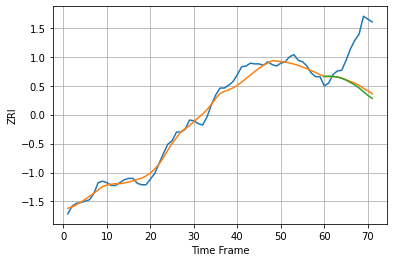

In [359]:
plot_series(timeline, actual)
plot_series(timeline, result)
plot_series(time_test, forecast)
plt.show()

In [323]:
len(forecast)

12

In [360]:
print(mean_squared_error(actual[:SPLIT-WINDOW_SIZE],result[:SPLIT-WINDOW_SIZE])**0.5 * scaler.var_[0]**0.5);
print(mean_squared_error(actual[SPLIT-WINDOW_SIZE:],result[SPLIT-WINDOW_SIZE:])**0.5 * scaler.var_[0]**0.5);
print(mean_squared_error(actual[SPLIT-WINDOW_SIZE:],forecast)**0.5 * scaler.var_[0]**0.5);

7.768731673295954
59.69501955411512
62.92695805924161


In [369]:
prediction = forecast * scaler.var_[0]**0.5 + scaler.mean_[0]

In [372]:
mean_squared_error(prediction, list(series_frame["zri"])[-12:])**0.5

62.92695805924163

### An issue of NN
Indeed, the estimation value is not very stable...

In [376]:
MSE_list = [];
for trials in range(100):
    model = NN_model(dataset_train);
    results, actual, forecast = NN_forecast(model, series_transformed);
    mse = mean_squared_error(actual[SPLIT-WINDOW_SIZE:],forecast)**0.5 * scaler.var_[0]**0.5
    print(mse);
    MSE_list.append(mse);

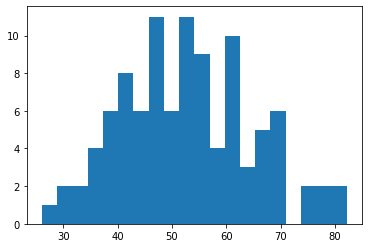

In [379]:
plt.hist(MSE_list, bins=20);

In [380]:
print(np.array(MSE_list).mean(),np.array(MSE_list).std())

52.90475144112681 12.221380425022122
